In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import math
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from mamba import *

In [2]:
stock_name = 'PEP'
df = yf.download(stock_name,
                 start='2016-06-01',
                 end='2019-01-26',
                 progress=False)
file_name = f'{stock_name}.csv'
df.to_csv(file_name)

In [3]:
df = pd.read_csv(file_name)
close_prices = df['Close']

In [4]:
print(close_prices.shape)

(668,)


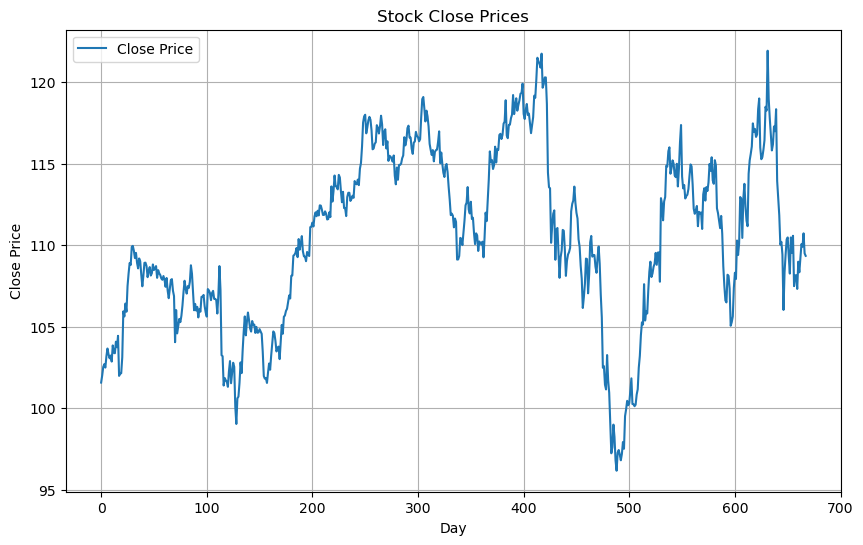

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Close Price')
plt.title('Stock Close Prices')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
pct_changes = close_prices.pct_change().dropna()*100

In [7]:
pct_changes = pct_changes.values.reshape(-1, 1)

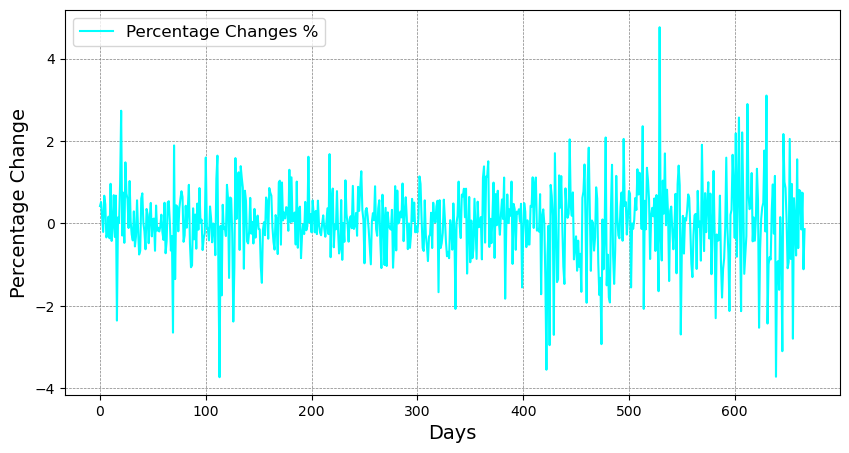

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes %')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pct_changes = scaler.fit_transform(pct_changes)

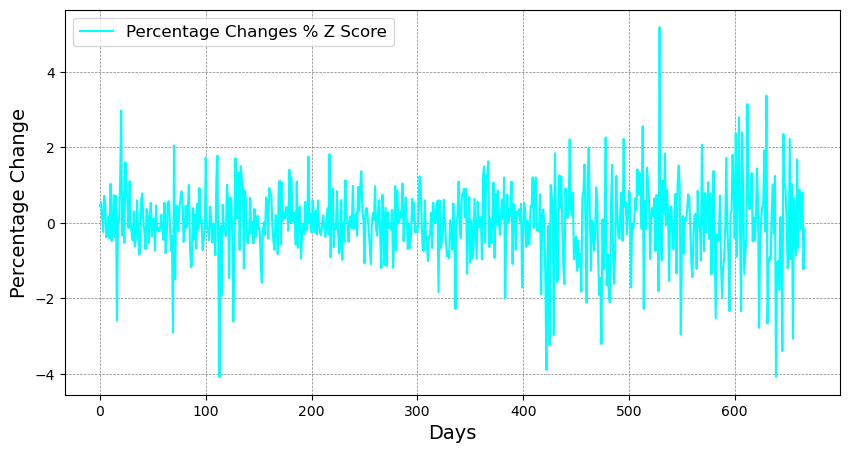

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes % Z Score')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

In [11]:
print(pct_changes.shape)

(667, 1)


In [12]:
def create_time_series_windows(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step):
        historical_data = dataset[i:(i+time_step), 0]
        features.append(historical_data)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)

Running model with lr=0.0001, epochs=110, time_step=10, batch_size=64


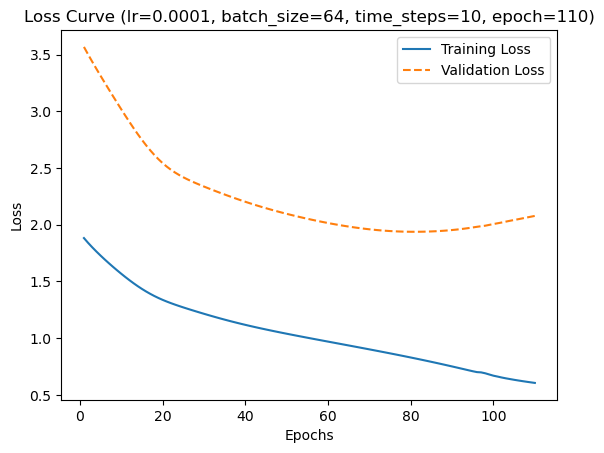

Running model with lr=0.0001, epochs=110, time_step=10, batch_size=32


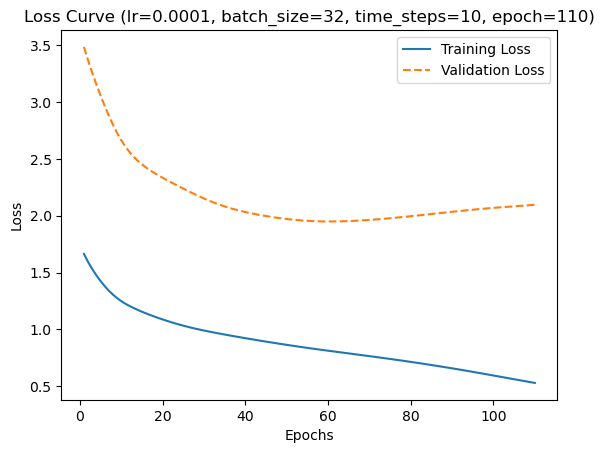

Running model with lr=0.0001, epochs=110, time_step=15, batch_size=64


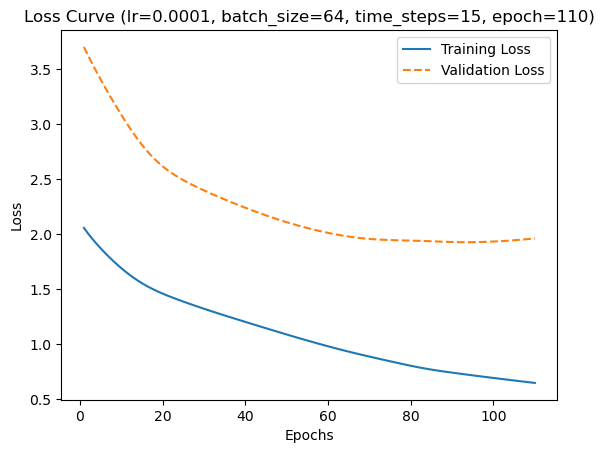

Running model with lr=0.0001, epochs=110, time_step=15, batch_size=32


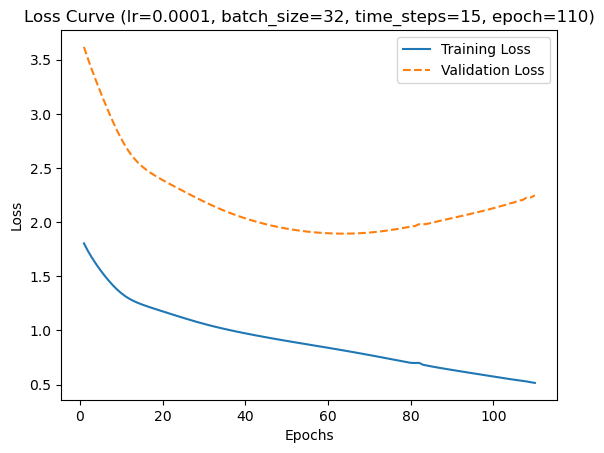

Running model with lr=0.0001, epochs=110, time_step=20, batch_size=64


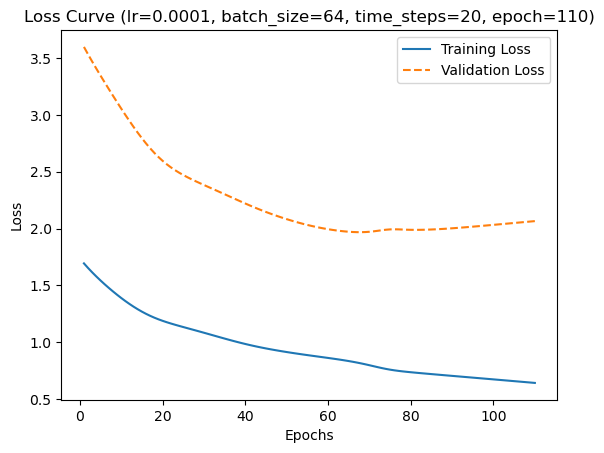

Running model with lr=0.0001, epochs=110, time_step=20, batch_size=32


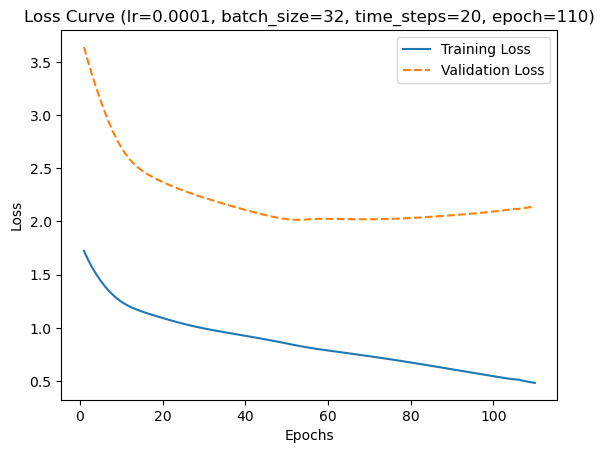

Running model with lr=0.0001, epochs=105, time_step=10, batch_size=64


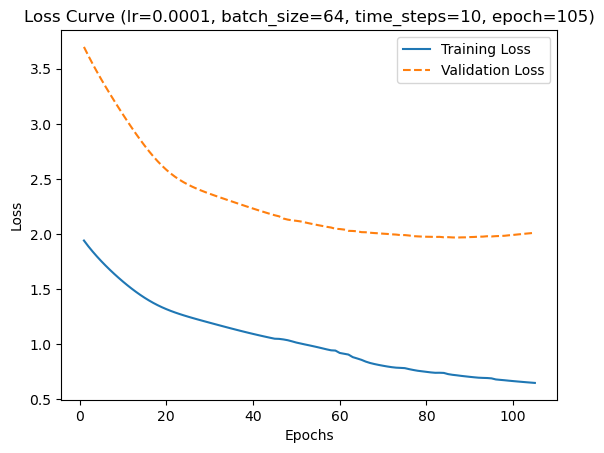

Running model with lr=0.0001, epochs=105, time_step=10, batch_size=32


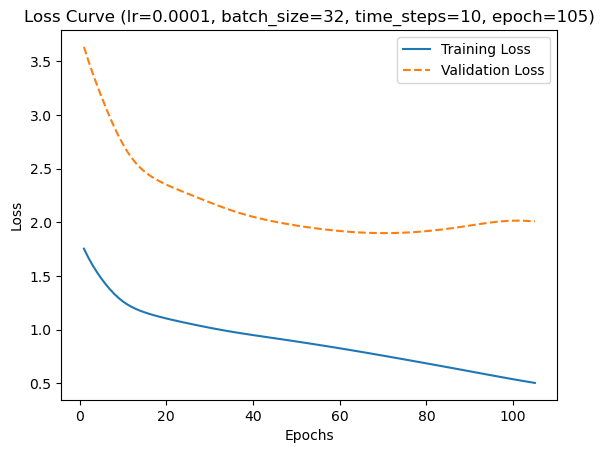

Running model with lr=0.0001, epochs=105, time_step=15, batch_size=64


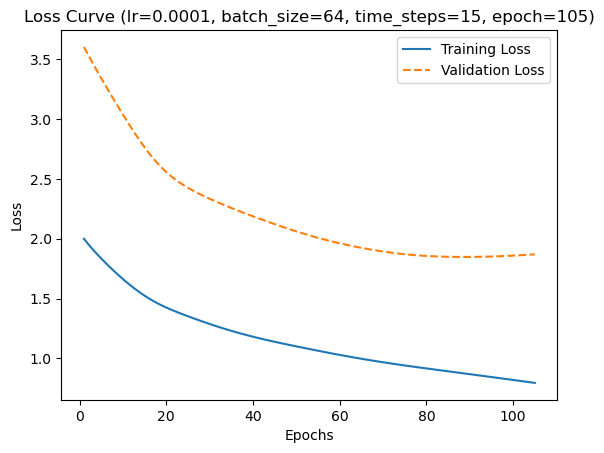

Running model with lr=0.0001, epochs=105, time_step=15, batch_size=32


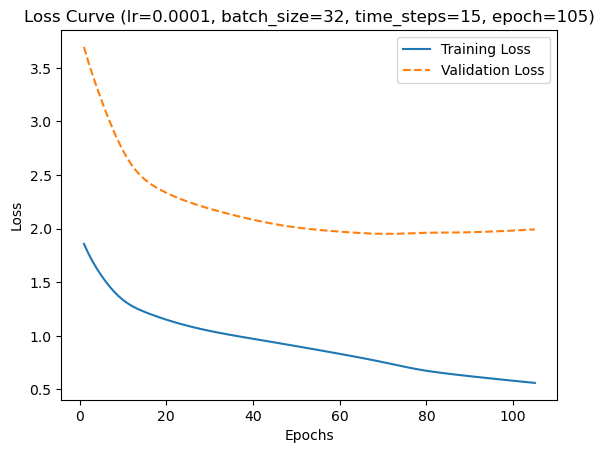

Running model with lr=0.0001, epochs=105, time_step=20, batch_size=64


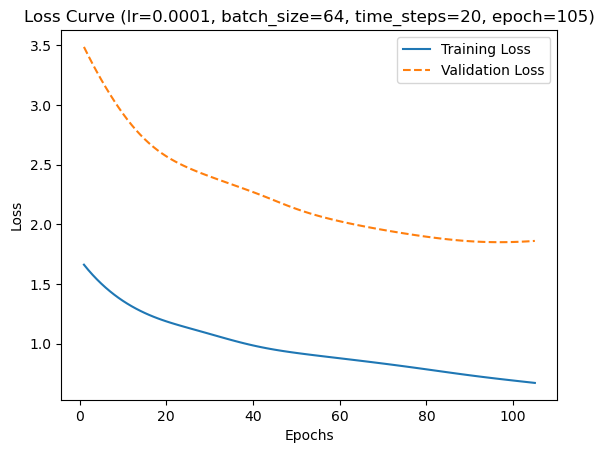

Running model with lr=0.0001, epochs=105, time_step=20, batch_size=32


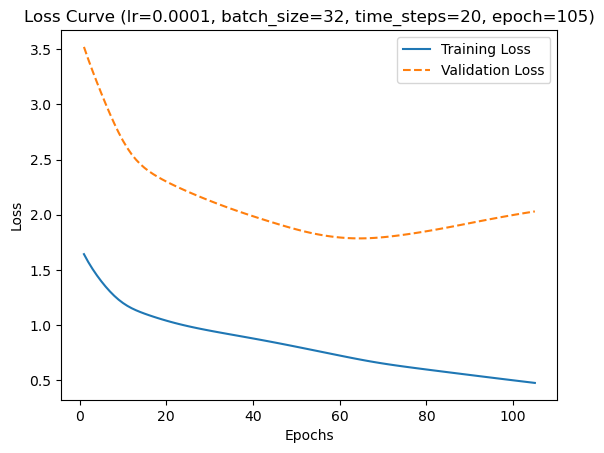

Running model with lr=0.0001, epochs=100, time_step=10, batch_size=64


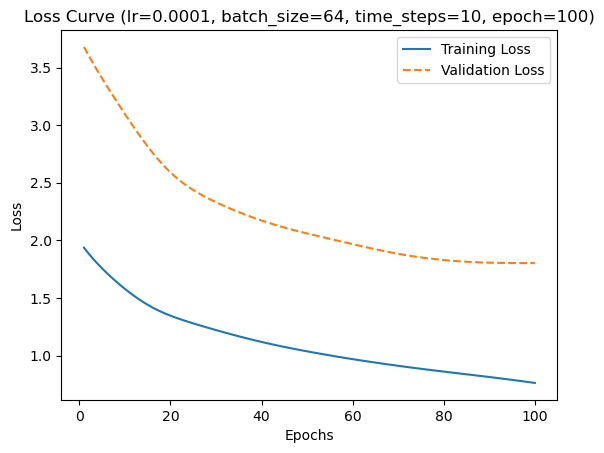

Running model with lr=0.0001, epochs=100, time_step=10, batch_size=32


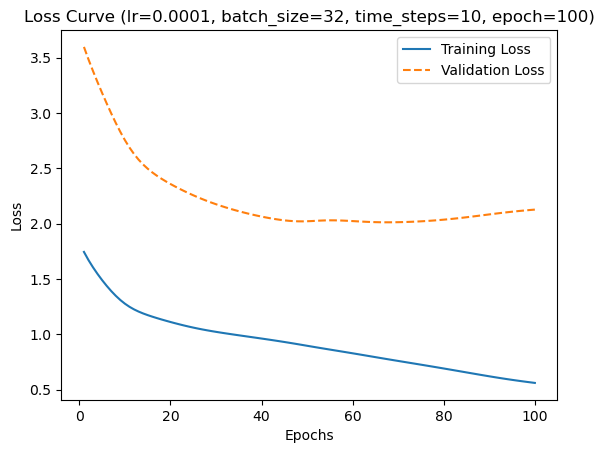

Running model with lr=0.0001, epochs=100, time_step=15, batch_size=64


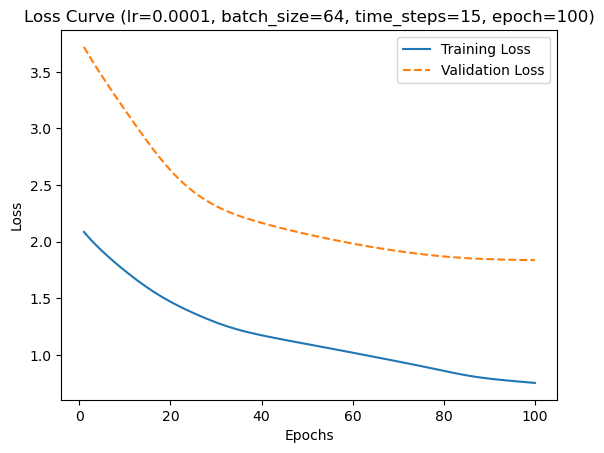

Running model with lr=0.0001, epochs=100, time_step=15, batch_size=32


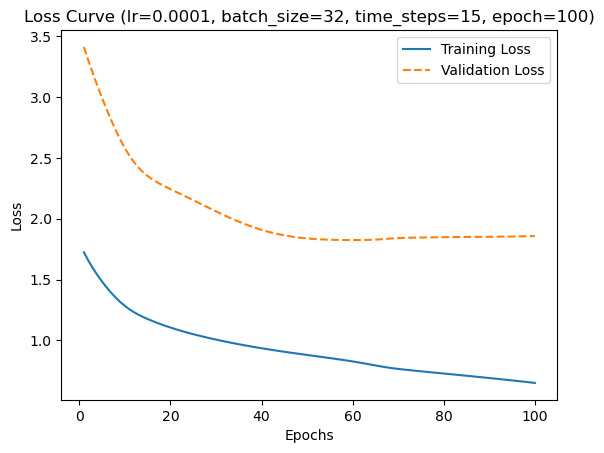

Running model with lr=0.0001, epochs=100, time_step=20, batch_size=64


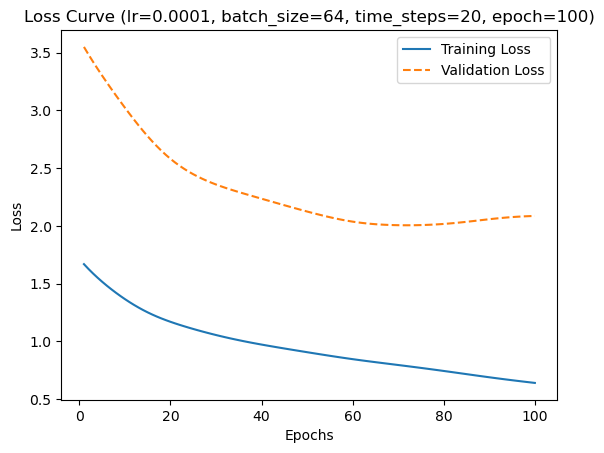

Running model with lr=0.0001, epochs=100, time_step=20, batch_size=32


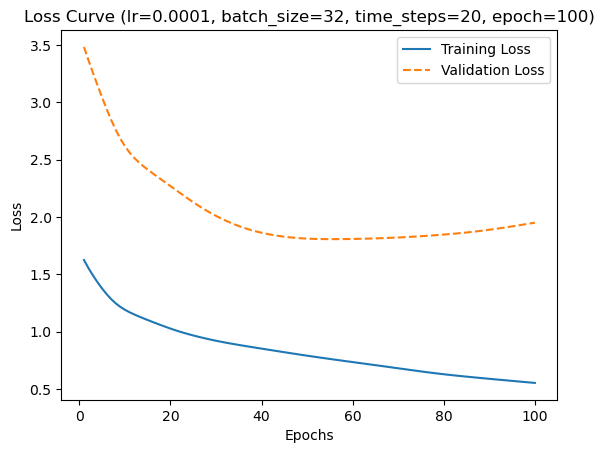

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from itertools import product  # For generating combinations

# Define model parameters
learning_rates = [0.0001]
epochs = [110, 105, 100]
time_steps = [10, 15, 20]
batch_sizes = [64,32]

# Create combinations of parameters (learning rate, epochs, time steps, batch size)
combinations = list(product(learning_rates, epochs, time_steps, batch_sizes))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_size = 120

# Initialize ensemble_results to store the predictions
ensemble_results = []

# Loop over parameter combinations
for lr, epoch_count, time_step, batch_size in combinations:
    print(f"Running model with lr={lr}, epochs={epoch_count}, time_step={time_step}, batch_size={batch_size}")

    # Create different time step dataset
    X, y = create_time_series_windows(pct_changes, time_step)
    training_size = len(X) - test_size
    X_train, X_test = X[0:training_size], X[training_size:]
    y_train, y_test = y[0:training_size], y[training_size:]
    
    # Reshape the data (assuming the scaler is already applied)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # Create DataLoader with varying batch sizes
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Define Mamba model configuration
    config = MambaConfig(
        d_model=32,
        n_layers=3,
        dt_rank='auto',
        d_state=16,
        expand_factor=2,
        d_conv=4,
        dt_min=0.001,
        dt_max=0.1,
        dt_init="random",
        dt_scale=1.0,
        bias=False,
        conv_bias=True,
        pscan=True
    )
    
    model = Mamba(config)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses = []
    validation_losses = []

    # Train the model
    for epoch in range(epoch_count):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            last_outputs = outputs[:, -1, -1]
            loss = criterion(last_outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            X_test_tensor = X_test.clone().detach().to(device).view(-1, time_step, 1)
            y_test_pred = model(X_test_tensor)[:, -1, -1]
            val_loss = criterion(y_test_pred, y_test.to(device)).item()
            validation_losses.append(val_loss)


    plt.figure()
    plt.plot(range(1, epoch_count + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epoch_count + 1), validation_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve (lr={lr}, batch_size={batch_size}, time_steps={time_step}, epoch={epoch_count})')
    plt.legend()
    plt.show()

    # Test mode and prediction
    model.eval()
    X_test_tensor = X_test.clone().detach().to(device).view(-1, time_step, 1)
    
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)[:, -1, -1].cpu().numpy()
        y_test_pred = y_test_pred.reshape(-1, 1)
        y_test_pred = scaler.inverse_transform(y_test_pred)
        y_test_binary_pred = np.where(y_test_pred > 0, 1, 0)
        ensemble_results.append(y_test_binary_pred)

# Convert predictions to a numpy array for further processing
ensemble_results = np.array(ensemble_results)


In [14]:
majority_voting_predictions = []

# Iterate through each column (i.e., for each test sample)
for i in range(ensemble_results.shape[1]):  # 120 test samples
    # Get the current column (predictions from all models for this test sample)
    column = ensemble_results[:, i]
    
    # Check if the majority of values in this column are 1 or 0
    if np.sum(column) > len(column) // 2:  # If sum of column is more than half, majority is 1
        majority_voting_predictions.append(1)
    else:
        majority_voting_predictions.append(0)

# Convert the majority voting predictions to a numpy array and reshape it to (120, 1)
majority_voting_predictions = np.array(majority_voting_predictions)

In [15]:
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)
y_test_binary = np.where(y_test > 0, 1, 0)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
# Sonuçları değerlendirme
accuracy = accuracy_score(y_test_binary, majority_voting_predictions)
precision = precision_score(y_test_binary, majority_voting_predictions)
recall = recall_score(y_test_binary, majority_voting_predictions)
balanced_accuracy = balanced_accuracy_score(y_test_binary, majority_voting_predictions)
f1 = f1_score(y_test_binary, majority_voting_predictions)

print(f"Ensemble Accuracy: {accuracy:.2f}")
print(f"Ensemble Precision: {precision:.2f}")
print(f"Ensemble Recall: {recall:.2f}")
print(f"Ensemble Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"Ensemble F1 Score: {f1:.2f}")

Ensemble Accuracy: 0.52
Ensemble Precision: 0.52
Ensemble Recall: 0.50
Ensemble Balanced Accuracy: 0.52
Ensemble F1 Score: 0.51


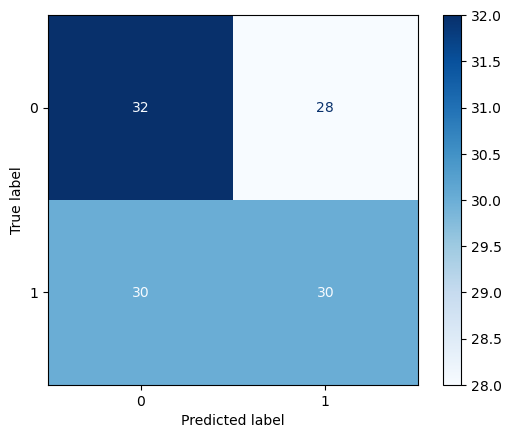

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_binary, majority_voting_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

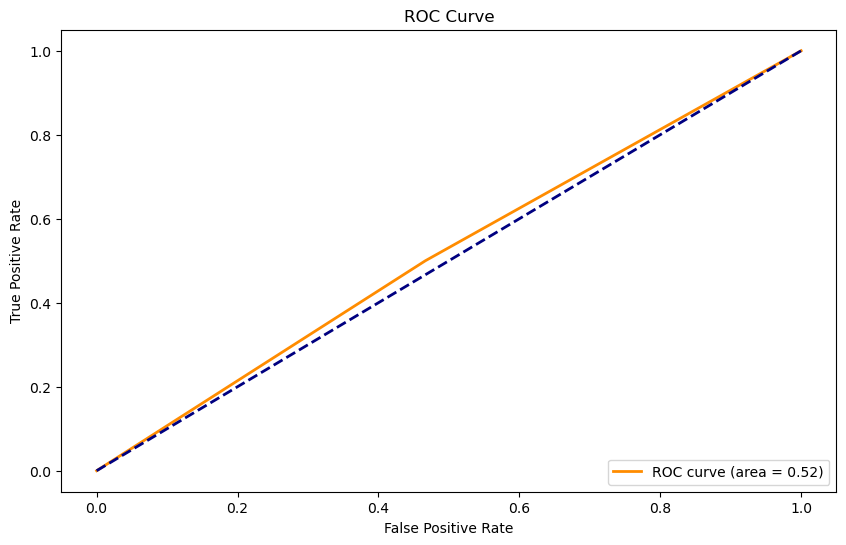

In [18]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_binary, majority_voting_predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

financial eval

In [19]:
df = df.drop(index=0)
df = df.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)
y_pred_binary = majority_voting_predictions.flatten()
df.loc[len(df) - len(y_pred_binary) + 1:len(df), 'y_test_pred_binary'] = y_pred_binary
new_df = df[['Date', 'Open', 'Close','y_test_pred_binary']].copy()
df = new_df.tail(len(y_pred_binary))
df = df.reset_index(drop=True)

In [20]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 
df['signal'] = ''

if df['y_test_pred_binary'].iloc[0] == 1:
    df.at[0, 'signal'] = 'buy'
elif df['y_test_pred_binary'].iloc[0] == 0:
    df.at[0, 'signal'] = 'sell'

for i in range(1, len(df)):
    if df['y_test_pred_binary'].iloc[i] != df['y_test_pred_binary'].iloc[i - 1]:
        if df['y_test_pred_binary'].iloc[i] == 1:
            df.at[i, 'signal'] = 'buy'
        elif df['y_test_pred_binary'].iloc[i] == 0:
            df.at[i, 'signal'] = 'sell'
    else:
        df.at[i, 'signal'] = ''

In [21]:
capital = 10000
stock_quantity = 0
borrowed_stock = 0
remaining_money_list = []
new_stock_list = []
borrowed_stock_list = []
#for visualisation start
total_value = 0
total_value_list = []
#bh:buy and hold
bh_value = 0
bh_value_list = []
first_opening = df.loc[0, 'Open']
bh_stock_quantity = capital / first_opening
#for visualisation end

for index, row in df.iterrows():
    signal = row['signal']
    opening_price = row['Open']

    if signal == 'buy':
        if borrowed_stock > 0:
            capital -= borrowed_stock*opening_price
            borrowed_stock = 0
        stock_quantity = capital / opening_price
        capital -= stock_quantity * opening_price
    elif signal == 'sell':
        capital += stock_quantity * opening_price
        stock_quantity = 0
        borrowed_stock = capital / opening_price
        capital += borrowed_stock*opening_price

    #for visualisation start
    closing_price = row['Close']
    total_value = (stock_quantity*closing_price)+(capital-(borrowed_stock*closing_price))
    total_value_list.append(total_value)
    bh_value = bh_stock_quantity*closing_price
    bh_value_list.append(bh_value)
    #for visualisation end
    remaining_money_list.append(capital)
    new_stock_list.append(stock_quantity)
    borrowed_stock_list.append(borrowed_stock)

df['Remaining_Money'] = remaining_money_list
df['New_Stock'] = new_stock_list
df['Borrowed_Stock'] = borrowed_stock_list
df['Total_Value'] = total_value_list
df['BH_Value'] = bh_value_list

print("Remaining Money")
remaining_money = df.loc[len(df) - 1, 'Remaining_Money']
print(remaining_money)
new_stock = df.loc[len(df) - 1, 'New_Stock']
print("New Stock")
print(new_stock)
print("Borrowed Stock")
borrowed = df.loc[len(df) - 1, 'Borrowed_Stock']
print(borrowed)
final_close = df.loc[len(df) - 1, 'Close']
print("Final Close")
print(final_close)
final_capital = ((final_close*new_stock)+remaining_money)-(borrowed*final_close)
print("Final Capital")
print(final_capital)
df.to_csv('financial.csv', index=False)

Remaining Money
0.0
New Stock
106.9678177970083
Borrowed Stock
0.0
Final Close
109.3499984741211
Final Capital
11696.93071288292


In [22]:
bh_final_capital = bh_stock_quantity * final_close
print("Buy And Hold Final Capital")
print(f"Buy and Hold: Capital = {bh_final_capital}")

Buy And Hold Final Capital
Buy and Hold: Capital = 9527.7513002112


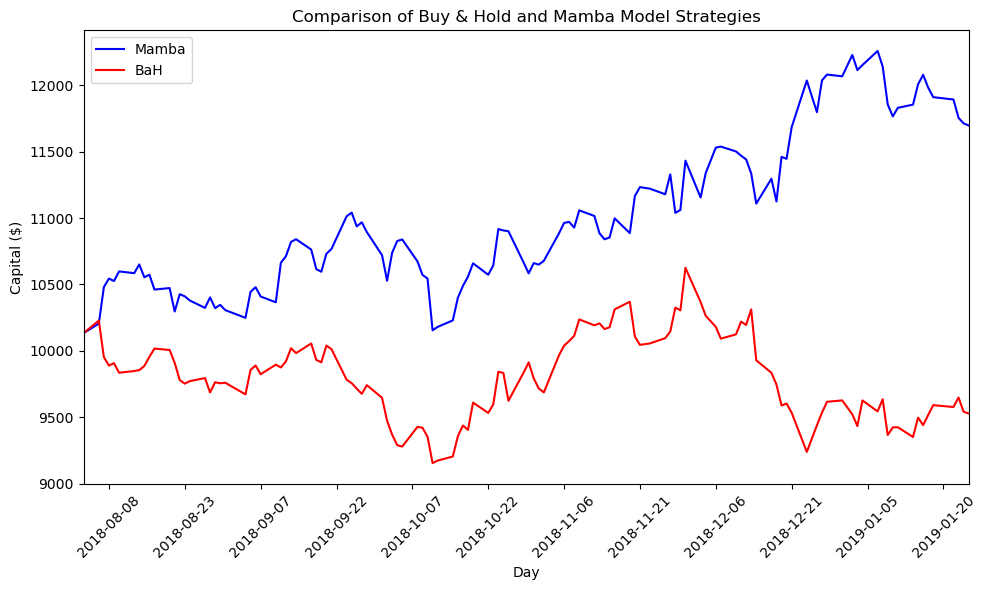

In [23]:
import matplotlib.dates as mdates
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Total_Value'], color='blue', label='Mamba')
plt.plot(df.index, df['BH_Value'], color='red', label='BaH')
plt.xlabel('Day')
plt.ylabel('Capital ($)')
plt.title('Comparison of Buy & Hold and Mamba Model Strategies')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.xticks(rotation=45)  
plt.xlim([df.index.min(), df.index.max()])
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os
pid = os.getpid()
!kill -9 $pid